cuda:0


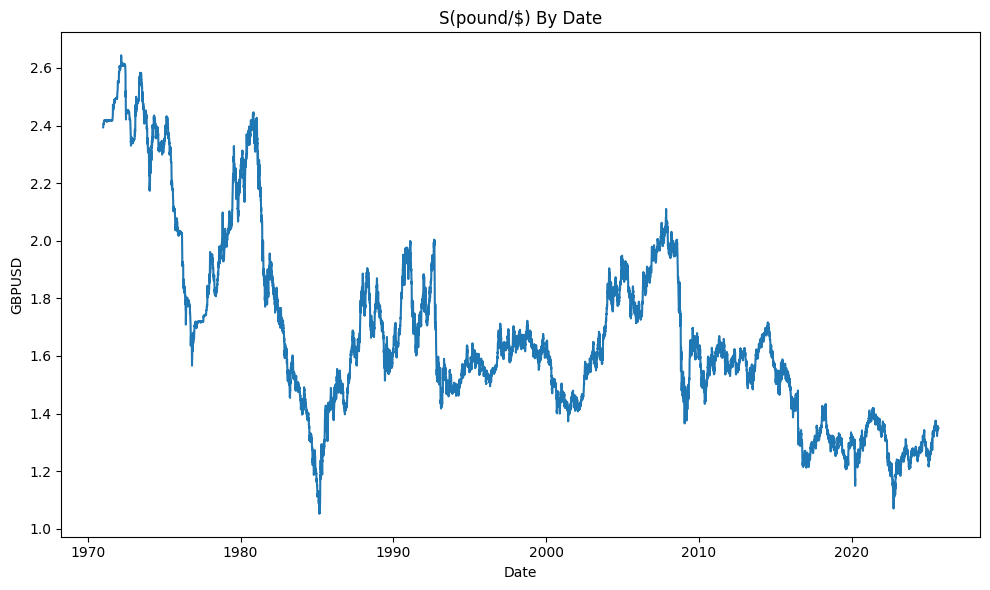

In [8]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



GBPUSD = fred.get_series("DEXUSUK")
GBPUSD.name = "GBPUSD"

df = pd.concat([GBPUSD],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='GBPUSD',data=df)
plt.title("S(pound/$) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






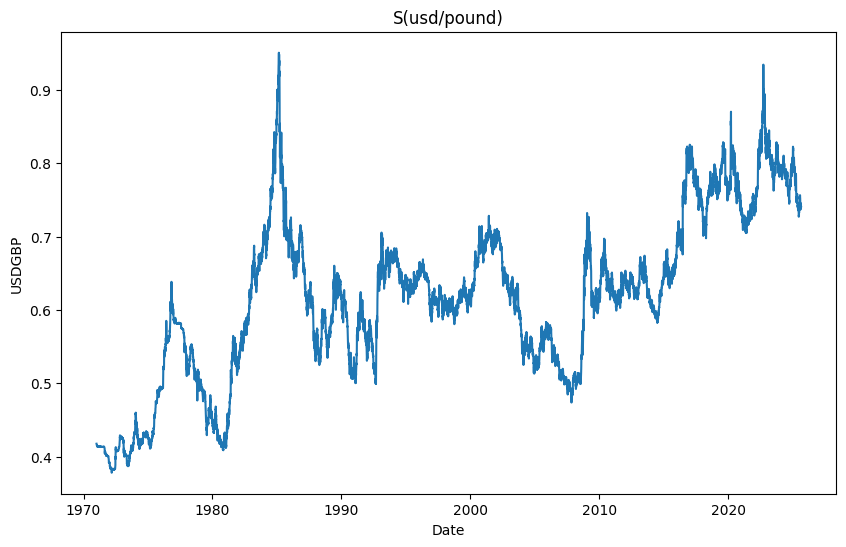

In [9]:



df['USDGBP'] = 1 / df['GBPUSD']

plt.figure(figsize=(10,6))
sns.lineplot(x=df['Date'],y=df['USDGBP'])
plt.title("S(usd/pound)")
plt.savefig("images/spotrate_USDGBP")
plt.show()




In [10]:

#there is no Arbitrage for trading currency pairs in the FX market
#1 / USDGBP == GBPUSD; 1 / GBPUSD == USDGBP"""



A = np.array([[df['USDGBP'][1],df['GBPUSD'][1]],[df['GBPUSD'][1],df['USDGBP'][1]]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[0.41755397 2.3949    ]
 [2.3949     0.41755397]]


In [12]:
df.drop("GBPUSD",inplace=True,axis=1)
df.drop_duplicates(inplace=True)

df_train = df.iloc[:,1:2].values



train_size = int(len(df_train) * .70)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out





In [13]:
model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')

/tmp/ipykernel_36204/1684662588.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_36204/1684662588.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.4027; Test RMSE: 0.6222
Epoch: 1; train_RMSE: 0.3921; Test RMSE: 0.61
Epoch: 2; train_RMSE: 0.3814; Test RMSE: 0.5978
Epoch: 3; train_RMSE: 0.3708; Test RMSE: 0.5856
Epoch: 4; train_RMSE: 0.3601; Test RMSE: 0.5732
Epoch: 5; train_RMSE: 0.3493; Test RMSE: 0.5606
Epoch: 6; train_RMSE: 0.3384; Test RMSE: 0.5479
Epoch: 7; train_RMSE: 0.3274; Test RMSE: 0.5349
Epoch: 8; train_RMSE: 0.3163; Test RMSE: 0.5216
Epoch: 9; train_RMSE: 0.3051; Test RMSE: 0.5081
Epoch: 10; train_RMSE: 0.2937; Test RMSE: 0.4942
Epoch: 11; train_RMSE: 0.2821; Test RMSE: 0.48
Epoch: 12; train_RMSE: 0.2704; Test RMSE: 0.4655
Epoch: 13; train_RMSE: 0.2587; Test RMSE: 0.4505
Epoch: 14; train_RMSE: 0.2468; Test RMSE: 0.4352
Epoch: 15; train_RMSE: 0.235; Test RMSE: 0.4195
Epoch: 16; train_RMSE: 0.2233; Test RMSE: 0.4034
Epoch: 17; train_RMSE: 0.2117; Test RMSE: 0.387
Epoch: 18; train_RMSE: 0.2005; Test RMSE: 0.3704
Epoch: 19; train_RMSE: 0.1898; Test RMSE: 0.3535
Epoch: 20; train_RMSE: 0.1797; Test 

Root Mean Squared Error: 0.0055
R2 Score: 99.47
Mean Average Percentage Error: 0.00557
         Date  Actual Spot Rate  Predicted Spot Rate
0  2009-03-27          0.698080             0.690200
1  2009-03-30          0.706814             0.698743
2  2009-03-31          0.699301             0.707772
3  2009-04-01          0.694348             0.700004
4  2009-04-02          0.680272             0.694891
5  2009-04-03          0.675630             0.680396
6  2009-04-06          0.679717             0.675627
7  2009-04-07          0.678242             0.679826
8  2009-04-08          0.680643             0.678310
9  2009-04-09          0.683854             0.680777
10 2009-04-10          0.683293             0.684080
11 2009-04-13          0.674263             0.683503
12 2009-04-14          0.670826             0.674224
13 2009-04-15          0.667111             0.670698
14 2009-04-16          0.670736             0.666891
15 2009-04-17          0.676682             0.670606
16 2009-04-2

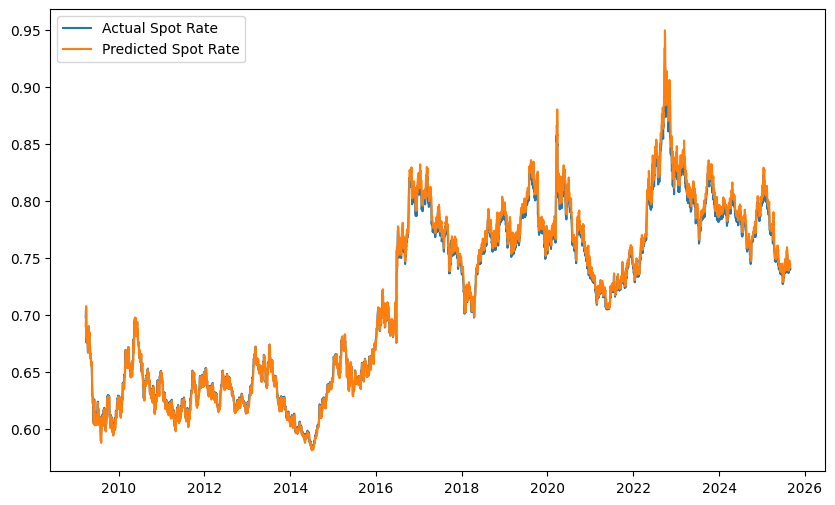

In [14]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


# Root-Mean Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Root Mean Squared Error: {rmse:.4f}")

# R2 Score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'R2 Score: {r2*100:.2f}')


# root mean average 
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f'Mean Average Percentage Error: {mape:.4}')


test_dates = df.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))


plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate-USD-GBP.png")
plt.show()
